# Question 2

Organise an event which the participants are from the class list. This event requires that the
students work together in groups. It is required to make sure the students who know each-other are not allocated in the same
group (just for ’ice-breaking’). For each group we need to pay 500 Euros to cover room/table/food fees (no matter how many
people are in that group). Considering the following table, what is the min cost for running this event?

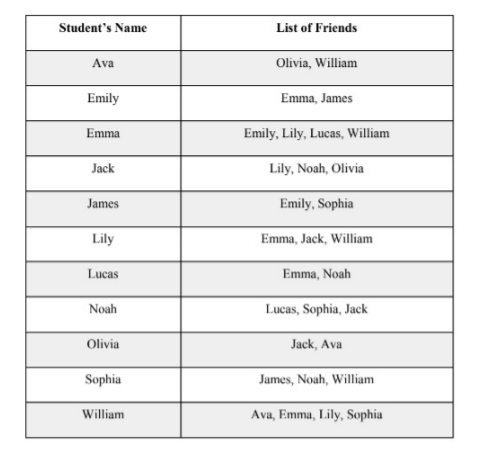

In [6]:
from IPython.display import Image
Image(filename="img/groups.png", width=400,height=400)

The .csv file containing a table stating whether each person is presons are not is converted to an easily usable dataframe

In [11]:
import pandas as pd   
from pyomo.environ import *
df_groups=pd.read_csv('Assignment_2_Q2.csv')
df_groups.columns=df_groups.columns.str.strip()
df_groups.head(11)

,name,1,2,3,4,5,6,7,8,9,10,11,Unnamed: 12
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
3,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
5,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
6,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
7,8.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
8,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN


Constarints and the OF for the minimum number of groups is found

In [12]:
model       = AbstractModel()
model.i     = RangeSet(11)    #Set to iterate through the rows containing a list of people
model.j     = RangeSet(11)    #Set to iterate through the columns containing a list of friendsor not friends
model.g     = RangeSet(11)    #Set containing a lsit of all possible groups
model.groupNum = Var( bounds=(0,9),domain=NonNegativeReals) #Number of groups that are used    
model.U     = Var(model.i,model.g, within=Binary)           #Binaryu varaible deciding if a person belongs to a group

#Creates 11 possible groups
def group(model,i):
    return df_groups.iloc[i-1,0]
model.group = Param(model.i, initialize=group,domain=NonNegativeReals)

#Provides info if person i is friends with person j
def rule_friend(model,i,j):
     return df_groups.iloc[i-1, j]
model.friend_ij = Param(model.i,model.j,initialize=rule_friend, mutable=True)

#Ensures no friends are placed in the same group
def con1_rule(model,i,j,g):
    return (model.U[i,g] + model.U[j,g])*model.friend_ij[i,j] <= 1
model.con1 = Constraint(model.i,model.j,model.g,rule=con1_rule)

#Sets constraint on the nuber of groups
def con2_rule(model,i,g):
    return model.groupNum >= model.group[g]*model.U[i,g]
model.con2 = Constraint(model.i,model.g,rule=con2_rule)

#Ensures a person is in exactly one group
def con3_rule(model,i,g):
    return sum(model.U[i,g] for g in model.g) == 1
model.con3 = Constraint(model.i,model.g,rule=con3_rule)

#Minimises the number of groups
def obj_rule(model):
    return model.groupNum
model.OF = Objective(rule=obj_rule,sense=minimize)

In [14]:
instance = model.create_instance()
opt = SolverFactory('glpk')
#opt = SolverFactory("glpk")
results = opt.solve(instance) # solves and updates instance
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)
print('OF=',round(value(instance.OF),2))

feasible
OF= 3.0


In [15]:
for g in instance.g:
    print('Group Number',g,' = ')
    for i in instance.i:
        if value(instance.U[i,g]) > 0:
            print(df_groups.iloc[i-1,0])
print('\n')
cost = 500*round(value(instance.OF),2)
print(round(value(instance.OF),2),"groups cost",cost,"euro")
#The results of the solver are presented.

Group Number 1  = 
1.0
3.0
4.0
Group Number 2  = 
2.0
6.0
7.0
10.0
Group Number 3  = 
5.0
8.0
9.0
11.0
Group Number 4  = 
Group Number 5  = 
Group Number 6  = 
Group Number 7  = 
Group Number 8  = 
Group Number 9  = 
Group Number 10  = 
Group Number 11  = 


3.0 groups cost 1500.0 euro


# Question 3 

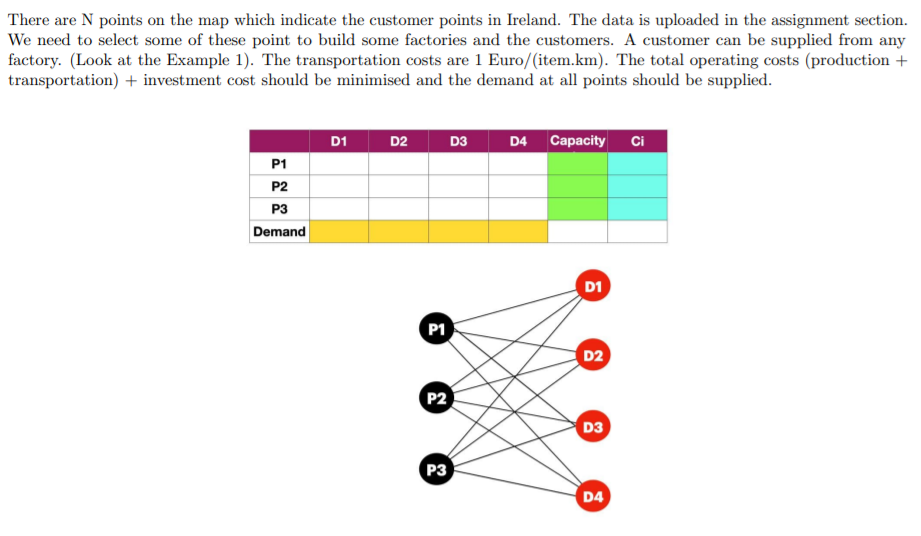

In [19]:
from IPython.display import Image
Image(filename="img/Supply_Demand.png", width=700,height=700)

Consider 15 points with the largest capacities as the locations of factories. So the location, capacity
and production cost/item is known for these factories. Now find the unknown decision variables.

In [512]:
from pyomo.environ import *
import numpy as np
import pandas as pd 
import gurobipy as gp
from gurobipy import GRB
import math

The csv file was sorted in order of capacity and read as a data frame

In [513]:
df=pd.read_csv('AttractionsPartA.csv')
df.columns=df.columns.str.strip()

In [514]:
model       = AbstractModel()
model.i=RangeSet(15)
model.j=RangeSet(16,543)
model.U_i = Var(model.i,within=Binary)
model.U_ij = Var(model.i,model.j,within=Binary)
model.P = Param(model.i,mutable=True, initialize = 0, within=NonNegativeIntegers)
model.X_ij = Var(model.i,model.j, domain=NonNegativeReals)

#Stores all demands from the factories
def rule_demand_factory(model,i):
     return df.loc[i, "Demand"]
model.Demand_i = Param(model.i,initialize=rule_demand_factory, within=NonNegativeIntegers)

#Stores all demands from the customers
def rule_demand_customer(model,j):
     return df.loc[j, "Demand"]
model.Demand_j = Param(model.j,initialize=rule_demand_customer, within=NonNegativeIntegers)

#stores all factory costs
def rule_cost(model,i):
     return df.loc[i, "Ci"]
model.cost_i = Param(model.i,initialize=rule_cost, within=NonNegativeIntegers)

#Stores all factory investements
def rule_investment(model,i):
     return df.loc[i, "Investment (1000 Euros)"]
model.investment_i = Param(model.i,initialize=rule_investment, within=NonNegativeIntegers)

#Stores all factory capacities
def rule_capacity_i(model,i):
     return df.loc[i, "Cap"]
model.capacity_i = Param(model.i,initialize=rule_capacity_i, within=NonNegativeIntegers)

#Uses haversine method to calculate distances between factory and customers
def rule_distance_ij(model,i,j):
    long_f =  df.loc[i, "Longitude"]
    long_c =  df.loc[j, "Longitude"]
    lat_f =   df.loc[i, "Latitude"]
    lat_c =   df.loc[j, "Latitude"]
    p = math.pi/180 
    a = 0.5 - cos((lat_f-lat_c)*p)/2 + cos(lat_c*p) * cos(lat_f*p) * (1-cos((long_f-long_c)*p))/2
    d = 12742 * asin(sqrt(a)) #2*R*asin..
    return d  
model.distance_ij = Param(model.i,model.j,initialize=rule_distance_ij, within=NonNegativeReals)

#The amount the factory gives to a customer should be less than its capacity.
#The binary variable is multiplied by the param instaead of the variable (same result) to prevent non-linearity
def con4_rule(model,i,j):
    return model.X_ij[i,j] <= model.capacity_i[i]*model.U_ij[i,j]
model.con4 = Constraint(model.i, model.j,rule=con4_rule)

#The amount given to a customer by all its delivering facories should be greater than or equal to its demand
def con5_rule(model,j):
    return sum(model.X_ij[i,j] for i in model.i) >= model.Demand_j[j]
model.con5 = Constraint(model.j,rule=con5_rule)

#Assuming each factory supplies itself the capacity must be greater than this amount
def con7_rule(model,i):
    return sum(model.X_ij[i,j] for j in model.j) + model.Demand_i[i] <= model.capacity_i[i]*model.U_i[i]
model.con7 = Constraint(model.i,rule=con7_rule)



def obj_rule(model):
    return sum(sum(model.X_ij[i,j]*model.distance_ij[i,j] for j in model.j) for i in model.i) + sum(model.cost_i[i]*(sum(model.X_ij[i,j] for j in model.j)+ model.Demand_i[i]) for i in model.i) + sum(model.U_i[i]*model.investment_i[i] for i in model.i)
model.OF = Objective(rule=obj_rule,sense=minimize)


In [515]:
opt = SolverFactory("gurobi", solver_io="python")          
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

feasible


In [516]:
count = 0
for i in instance.i:
    for j in instance.j:
        print('X[',i,j,']=', round(value(instance.X_ij[i,j]),2))
        if(round(value(instance.X_ij[i,j]),2)>=1):
            count = count+1
print('OF=',round(value(instance.OF),2))
print(count)
#Results show the amount transported between factories and customers

X[ 1 16 ]= 10.0
X[ 1 17 ]= 0.0
X[ 1 18 ]= 0.0
X[ 1 19 ]= 0.0
X[ 1 20 ]= 0.0
X[ 1 21 ]= 4.0
X[ 1 22 ]= 0.0
X[ 1 23 ]= 0.0
X[ 1 24 ]= 0.0
X[ 1 25 ]= 0.0
X[ 1 26 ]= 0.0
X[ 1 27 ]= 0.0
X[ 1 28 ]= 0.0
X[ 1 29 ]= 0.0
X[ 1 30 ]= 0.0
X[ 1 31 ]= 0.0
X[ 1 32 ]= 0.0
X[ 1 33 ]= 0.0
X[ 1 34 ]= 0.0
X[ 1 35 ]= 0.0
X[ 1 36 ]= 0.0
X[ 1 37 ]= 0.0
X[ 1 38 ]= 0.0
X[ 1 39 ]= 0.0
X[ 1 40 ]= 0.0
X[ 1 41 ]= 0.0
X[ 1 42 ]= 0.0
X[ 1 43 ]= 0.0
X[ 1 44 ]= 0.0
X[ 1 45 ]= 0.0
X[ 1 46 ]= 12.0
X[ 1 47 ]= 0.0
X[ 1 48 ]= 0.0
X[ 1 49 ]= 0.0
X[ 1 50 ]= 0.0
X[ 1 51 ]= 0.0
X[ 1 52 ]= 12.0
X[ 1 53 ]= 0.0
X[ 1 54 ]= 0.0
X[ 1 55 ]= 0.0
X[ 1 56 ]= 0.0
X[ 1 57 ]= 0.0
X[ 1 58 ]= 0.0
X[ 1 59 ]= 0.0
X[ 1 60 ]= 7.0
X[ 1 61 ]= 0.0
X[ 1 62 ]= 0.0
X[ 1 63 ]= 9.0
X[ 1 64 ]= 0.0
X[ 1 65 ]= 0.0
X[ 1 66 ]= 0.0
X[ 1 67 ]= 0.0
X[ 1 68 ]= 0.0
X[ 1 69 ]= 11.0
X[ 1 70 ]= 0.0
X[ 1 71 ]= 0.0
X[ 1 72 ]= 0.0
X[ 1 73 ]= 0.0
X[ 1 74 ]= 0.0
X[ 1 75 ]= 0.0
X[ 1 76 ]= 0.0
X[ 1 77 ]= 0.0
X[ 1 78 ]= 0.0
X[ 1 79 ]= 0.0
X[ 1 80 ]= 0.0
X[ 1 81 ]= 0.0
X[ 1 8

X[ 2 112 ]= 0.0
X[ 2 113 ]= 0.0
X[ 2 114 ]= 0.0
X[ 2 115 ]= 0.0
X[ 2 116 ]= 0.0
X[ 2 117 ]= 0.0
X[ 2 118 ]= 0.0
X[ 2 119 ]= 0.0
X[ 2 120 ]= 0.0
X[ 2 121 ]= 0.0
X[ 2 122 ]= 0.0
X[ 2 123 ]= 0.0
X[ 2 124 ]= 0.0
X[ 2 125 ]= 0.0
X[ 2 126 ]= 7.0
X[ 2 127 ]= 0.0
X[ 2 128 ]= 0.0
X[ 2 129 ]= 8.0
X[ 2 130 ]= 0.0
X[ 2 131 ]= 0.0
X[ 2 132 ]= 0.0
X[ 2 133 ]= 0.0
X[ 2 134 ]= 0.0
X[ 2 135 ]= 0.0
X[ 2 136 ]= 0.0
X[ 2 137 ]= 0.0
X[ 2 138 ]= 0.0
X[ 2 139 ]= 0.0
X[ 2 140 ]= 0.0
X[ 2 141 ]= 0.0
X[ 2 142 ]= 0.0
X[ 2 143 ]= 0.0
X[ 2 144 ]= 0.0
X[ 2 145 ]= 0.0
X[ 2 146 ]= 0.0
X[ 2 147 ]= 0.0
X[ 2 148 ]= 0.0
X[ 2 149 ]= 0.0
X[ 2 150 ]= 0.0
X[ 2 151 ]= 0.0
X[ 2 152 ]= 0.0
X[ 2 153 ]= 0.0
X[ 2 154 ]= 0.0
X[ 2 155 ]= 0.0
X[ 2 156 ]= 0.0
X[ 2 157 ]= 0.0
X[ 2 158 ]= 0.0
X[ 2 159 ]= 0.0
X[ 2 160 ]= 0.0
X[ 2 161 ]= 0.0
X[ 2 162 ]= 0.0
X[ 2 163 ]= 0.0
X[ 2 164 ]= 0.0
X[ 2 165 ]= 0.0
X[ 2 166 ]= 0.0
X[ 2 167 ]= 0.0
X[ 2 168 ]= 0.0
X[ 2 169 ]= 0.0
X[ 2 170 ]= 0.0
X[ 2 171 ]= 0.0
X[ 2 172 ]= 0.0
X[ 2 173 ]= 0.0
X[ 2 174

X[ 3 284 ]= 0.0
X[ 3 285 ]= 0.0
X[ 3 286 ]= 0.0
X[ 3 287 ]= 0.0
X[ 3 288 ]= 0.0
X[ 3 289 ]= 0.0
X[ 3 290 ]= 0.0
X[ 3 291 ]= 0.0
X[ 3 292 ]= 0.0
X[ 3 293 ]= 0.0
X[ 3 294 ]= 0.0
X[ 3 295 ]= 0.0
X[ 3 296 ]= 0.0
X[ 3 297 ]= 0.0
X[ 3 298 ]= 0.0
X[ 3 299 ]= 10.0
X[ 3 300 ]= 0.0
X[ 3 301 ]= 0.0
X[ 3 302 ]= 0.0
X[ 3 303 ]= 0.0
X[ 3 304 ]= 0.0
X[ 3 305 ]= 0.0
X[ 3 306 ]= 0.0
X[ 3 307 ]= 0.0
X[ 3 308 ]= 0.0
X[ 3 309 ]= 0.0
X[ 3 310 ]= 0.0
X[ 3 311 ]= 0.0
X[ 3 312 ]= 0.0
X[ 3 313 ]= 0.0
X[ 3 314 ]= 0.0
X[ 3 315 ]= 0.0
X[ 3 316 ]= 0.0
X[ 3 317 ]= 0.0
X[ 3 318 ]= 0.0
X[ 3 319 ]= 0.0
X[ 3 320 ]= 3.0
X[ 3 321 ]= 0.0
X[ 3 322 ]= 8.0
X[ 3 323 ]= 0.0
X[ 3 324 ]= 0.0
X[ 3 325 ]= 0.0
X[ 3 326 ]= 0.0
X[ 3 327 ]= 0.0
X[ 3 328 ]= 0.0
X[ 3 329 ]= 0.0
X[ 3 330 ]= 0.0
X[ 3 331 ]= 0.0
X[ 3 332 ]= 0.0
X[ 3 333 ]= 0.0
X[ 3 334 ]= 0.0
X[ 3 335 ]= 3.0
X[ 3 336 ]= 0.0
X[ 3 337 ]= 0.0
X[ 3 338 ]= 0.0
X[ 3 339 ]= 0.0
X[ 3 340 ]= 0.0
X[ 3 341 ]= 3.0
X[ 3 342 ]= 0.0
X[ 3 343 ]= 0.0
X[ 3 344 ]= 0.0
X[ 3 345 ]= 0.0
X[ 3 34

X[ 4 456 ]= 0.0
X[ 4 457 ]= 0.0
X[ 4 458 ]= 0.0
X[ 4 459 ]= 0.0
X[ 4 460 ]= 0.0
X[ 4 461 ]= 0.0
X[ 4 462 ]= 0.0
X[ 4 463 ]= 0.0
X[ 4 464 ]= 0.0
X[ 4 465 ]= 0.0
X[ 4 466 ]= 0.0
X[ 4 467 ]= 0.0
X[ 4 468 ]= 0.0
X[ 4 469 ]= 0.0
X[ 4 470 ]= 0.0
X[ 4 471 ]= 0.0
X[ 4 472 ]= 0.0
X[ 4 473 ]= 0.0
X[ 4 474 ]= 0.0
X[ 4 475 ]= 0.0
X[ 4 476 ]= 0.0
X[ 4 477 ]= 0.0
X[ 4 478 ]= 0.0
X[ 4 479 ]= 0.0
X[ 4 480 ]= 0.0
X[ 4 481 ]= 0.0
X[ 4 482 ]= 0.0
X[ 4 483 ]= 0.0
X[ 4 484 ]= 0.0
X[ 4 485 ]= 0.0
X[ 4 486 ]= 0.0
X[ 4 487 ]= 0.0
X[ 4 488 ]= 0.0
X[ 4 489 ]= 0.0
X[ 4 490 ]= 0.0
X[ 4 491 ]= 0.0
X[ 4 492 ]= 12.0
X[ 4 493 ]= 0.0
X[ 4 494 ]= 0.0
X[ 4 495 ]= 0.0
X[ 4 496 ]= 0.0
X[ 4 497 ]= 0.0
X[ 4 498 ]= 0.0
X[ 4 499 ]= 7.0
X[ 4 500 ]= 0.0
X[ 4 501 ]= 0.0
X[ 4 502 ]= 0.0
X[ 4 503 ]= 0.0
X[ 4 504 ]= 0.0
X[ 4 505 ]= 0.0
X[ 4 506 ]= 0.0
X[ 4 507 ]= 0.0
X[ 4 508 ]= 0.0
X[ 4 509 ]= 0.0
X[ 4 510 ]= 9.0
X[ 4 511 ]= 0.0
X[ 4 512 ]= 0.0
X[ 4 513 ]= 6.0
X[ 4 514 ]= 0.0
X[ 4 515 ]= 0.0
X[ 4 516 ]= 0.0
X[ 4 517 ]= 0.0
X[ 4 51

X[ 6 126 ]= 0.0
X[ 6 127 ]= 0.0
X[ 6 128 ]= 0.0
X[ 6 129 ]= 0.0
X[ 6 130 ]= 0.0
X[ 6 131 ]= 0.0
X[ 6 132 ]= 0.0
X[ 6 133 ]= 0.0
X[ 6 134 ]= 0.0
X[ 6 135 ]= 0.0
X[ 6 136 ]= 0.0
X[ 6 137 ]= 0.0
X[ 6 138 ]= 0.0
X[ 6 139 ]= 0.0
X[ 6 140 ]= 0.0
X[ 6 141 ]= 0.0
X[ 6 142 ]= 0.0
X[ 6 143 ]= 0.0
X[ 6 144 ]= 0.0
X[ 6 145 ]= 0.0
X[ 6 146 ]= 0.0
X[ 6 147 ]= 0.0
X[ 6 148 ]= 0.0
X[ 6 149 ]= 0.0
X[ 6 150 ]= 0.0
X[ 6 151 ]= 0.0
X[ 6 152 ]= 0.0
X[ 6 153 ]= 0.0
X[ 6 154 ]= 0.0
X[ 6 155 ]= 0.0
X[ 6 156 ]= 0.0
X[ 6 157 ]= 0.0
X[ 6 158 ]= 0.0
X[ 6 159 ]= 0.0
X[ 6 160 ]= 0.0
X[ 6 161 ]= 0.0
X[ 6 162 ]= 5.0
X[ 6 163 ]= 0.0
X[ 6 164 ]= 0.0
X[ 6 165 ]= 0.0
X[ 6 166 ]= 0.0
X[ 6 167 ]= 0.0
X[ 6 168 ]= 0.0
X[ 6 169 ]= 0.0
X[ 6 170 ]= 0.0
X[ 6 171 ]= 0.0
X[ 6 172 ]= 6.0
X[ 6 173 ]= 0.0
X[ 6 174 ]= 0.0
X[ 6 175 ]= 0.0
X[ 6 176 ]= 0.0
X[ 6 177 ]= 0.0
X[ 6 178 ]= 0.0
X[ 6 179 ]= 0.0
X[ 6 180 ]= 0.0
X[ 6 181 ]= 0.0
X[ 6 182 ]= 0.0
X[ 6 183 ]= 0.0
X[ 6 184 ]= 0.0
X[ 6 185 ]= 0.0
X[ 6 186 ]= 0.0
X[ 6 187 ]= 0.0
X[ 6 188

X[ 7 371 ]= 0.0
X[ 7 372 ]= 0.0
X[ 7 373 ]= 0.0
X[ 7 374 ]= 0.0
X[ 7 375 ]= 0.0
X[ 7 376 ]= 0.0
X[ 7 377 ]= 0.0
X[ 7 378 ]= 0.0
X[ 7 379 ]= 0.0
X[ 7 380 ]= 0.0
X[ 7 381 ]= 0.0
X[ 7 382 ]= 0.0
X[ 7 383 ]= 0.0
X[ 7 384 ]= 0.0
X[ 7 385 ]= 0.0
X[ 7 386 ]= 0.0
X[ 7 387 ]= 0.0
X[ 7 388 ]= 0.0
X[ 7 389 ]= 0.0
X[ 7 390 ]= 9.0
X[ 7 391 ]= 0.0
X[ 7 392 ]= 0.0
X[ 7 393 ]= 0.0
X[ 7 394 ]= 0.0
X[ 7 395 ]= 0.0
X[ 7 396 ]= 0.0
X[ 7 397 ]= 0.0
X[ 7 398 ]= 0.0
X[ 7 399 ]= 0.0
X[ 7 400 ]= 0.0
X[ 7 401 ]= 0.0
X[ 7 402 ]= 0.0
X[ 7 403 ]= 0.0
X[ 7 404 ]= 0.0
X[ 7 405 ]= 11.0
X[ 7 406 ]= 0.0
X[ 7 407 ]= 0.0
X[ 7 408 ]= 0.0
X[ 7 409 ]= 0.0
X[ 7 410 ]= 0.0
X[ 7 411 ]= 0.0
X[ 7 412 ]= 8.0
X[ 7 413 ]= 0.0
X[ 7 414 ]= 0.0
X[ 7 415 ]= 9.0
X[ 7 416 ]= 0.0
X[ 7 417 ]= 0.0
X[ 7 418 ]= 0.0
X[ 7 419 ]= 0.0
X[ 7 420 ]= 0.0
X[ 7 421 ]= 0.0
X[ 7 422 ]= 0.0
X[ 7 423 ]= 0.0
X[ 7 424 ]= 0.0
X[ 7 425 ]= 0.0
X[ 7 426 ]= 0.0
X[ 7 427 ]= 0.0
X[ 7 428 ]= 0.0
X[ 7 429 ]= 0.0
X[ 7 430 ]= 0.0
X[ 7 431 ]= 0.0
X[ 7 432 ]= 0.0
X[ 7 43

X[ 9 115 ]= 0.0
X[ 9 116 ]= 0.0
X[ 9 117 ]= 0.0
X[ 9 118 ]= 0.0
X[ 9 119 ]= 0.0
X[ 9 120 ]= 0.0
X[ 9 121 ]= 0.0
X[ 9 122 ]= 0.0
X[ 9 123 ]= 0.0
X[ 9 124 ]= 0.0
X[ 9 125 ]= 3.0
X[ 9 126 ]= 0.0
X[ 9 127 ]= 0.0
X[ 9 128 ]= 0.0
X[ 9 129 ]= 0.0
X[ 9 130 ]= 0.0
X[ 9 131 ]= 0.0
X[ 9 132 ]= 0.0
X[ 9 133 ]= 0.0
X[ 9 134 ]= 0.0
X[ 9 135 ]= 0.0
X[ 9 136 ]= 5.0
X[ 9 137 ]= 0.0
X[ 9 138 ]= 0.0
X[ 9 139 ]= 0.0
X[ 9 140 ]= 0.0
X[ 9 141 ]= 0.0
X[ 9 142 ]= 0.0
X[ 9 143 ]= 0.0
X[ 9 144 ]= 0.0
X[ 9 145 ]= 0.0
X[ 9 146 ]= 0.0
X[ 9 147 ]= 0.0
X[ 9 148 ]= 0.0
X[ 9 149 ]= 0.0
X[ 9 150 ]= 0.0
X[ 9 151 ]= 0.0
X[ 9 152 ]= 0.0
X[ 9 153 ]= 0.0
X[ 9 154 ]= 0.0
X[ 9 155 ]= 10.0
X[ 9 156 ]= 0.0
X[ 9 157 ]= 0.0
X[ 9 158 ]= 0.0
X[ 9 159 ]= 12.0
X[ 9 160 ]= 0.0
X[ 9 161 ]= 0.0
X[ 9 162 ]= 0.0
X[ 9 163 ]= 0.0
X[ 9 164 ]= 0.0
X[ 9 165 ]= 0.0
X[ 9 166 ]= 0.0
X[ 9 167 ]= 0.0
X[ 9 168 ]= 0.0
X[ 9 169 ]= 0.0
X[ 9 170 ]= 0.0
X[ 9 171 ]= 0.0
X[ 9 172 ]= 0.0
X[ 9 173 ]= 0.0
X[ 9 174 ]= 8.0
X[ 9 175 ]= 0.0
X[ 9 176 ]= 0.0
X[ 9 1

X[ 10 387 ]= 0.0
X[ 10 388 ]= 0.0
X[ 10 389 ]= 0.0
X[ 10 390 ]= 0.0
X[ 10 391 ]= 0.0
X[ 10 392 ]= 0.0
X[ 10 393 ]= 7.0
X[ 10 394 ]= 0.0
X[ 10 395 ]= 0.0
X[ 10 396 ]= 0.0
X[ 10 397 ]= 0.0
X[ 10 398 ]= 0.0
X[ 10 399 ]= 0.0
X[ 10 400 ]= 0.0
X[ 10 401 ]= 0.0
X[ 10 402 ]= 0.0
X[ 10 403 ]= 0.0
X[ 10 404 ]= 0.0
X[ 10 405 ]= 0.0
X[ 10 406 ]= 0.0
X[ 10 407 ]= 0.0
X[ 10 408 ]= 7.0
X[ 10 409 ]= 0.0
X[ 10 410 ]= 0.0
X[ 10 411 ]= 0.0
X[ 10 412 ]= 0.0
X[ 10 413 ]= 0.0
X[ 10 414 ]= 0.0
X[ 10 415 ]= 0.0
X[ 10 416 ]= 0.0
X[ 10 417 ]= 7.0
X[ 10 418 ]= 0.0
X[ 10 419 ]= 0.0
X[ 10 420 ]= 0.0
X[ 10 421 ]= 4.0
X[ 10 422 ]= 0.0
X[ 10 423 ]= 0.0
X[ 10 424 ]= 8.0
X[ 10 425 ]= 0.0
X[ 10 426 ]= 10.0
X[ 10 427 ]= 0.0
X[ 10 428 ]= 0.0
X[ 10 429 ]= 0.0
X[ 10 430 ]= 0.0
X[ 10 431 ]= 0.0
X[ 10 432 ]= 0.0
X[ 10 433 ]= 0.0
X[ 10 434 ]= 0.0
X[ 10 435 ]= 0.0
X[ 10 436 ]= 0.0
X[ 10 437 ]= 0.0
X[ 10 438 ]= 0.0
X[ 10 439 ]= 0.0
X[ 10 440 ]= 0.0
X[ 10 441 ]= 0.0
X[ 10 442 ]= 0.0
X[ 10 443 ]= 0.0
X[ 10 444 ]= 0.0
X[ 10 445 ]= 

X[ 12 131 ]= 0.0
X[ 12 132 ]= 0.0
X[ 12 133 ]= 0.0
X[ 12 134 ]= 0.0
X[ 12 135 ]= 0.0
X[ 12 136 ]= 0.0
X[ 12 137 ]= 0.0
X[ 12 138 ]= 0.0
X[ 12 139 ]= 0.0
X[ 12 140 ]= 0.0
X[ 12 141 ]= 0.0
X[ 12 142 ]= 0.0
X[ 12 143 ]= 0.0
X[ 12 144 ]= 4.0
X[ 12 145 ]= 0.0
X[ 12 146 ]= 0.0
X[ 12 147 ]= 9.0
X[ 12 148 ]= 4.0
X[ 12 149 ]= 0.0
X[ 12 150 ]= 0.0
X[ 12 151 ]= 6.0
X[ 12 152 ]= 0.0
X[ 12 153 ]= 0.0
X[ 12 154 ]= 0.0
X[ 12 155 ]= 0.0
X[ 12 156 ]= 0.0
X[ 12 157 ]= 0.0
X[ 12 158 ]= 0.0
X[ 12 159 ]= 0.0
X[ 12 160 ]= 11.0
X[ 12 161 ]= 0.0
X[ 12 162 ]= 0.0
X[ 12 163 ]= 0.0
X[ 12 164 ]= 0.0
X[ 12 165 ]= 0.0
X[ 12 166 ]= 0.0
X[ 12 167 ]= 0.0
X[ 12 168 ]= 0.0
X[ 12 169 ]= 12.0
X[ 12 170 ]= 0.0
X[ 12 171 ]= 0.0
X[ 12 172 ]= 0.0
X[ 12 173 ]= 0.0
X[ 12 174 ]= 0.0
X[ 12 175 ]= 0.0
X[ 12 176 ]= 0.0
X[ 12 177 ]= 0.0
X[ 12 178 ]= 0.0
X[ 12 179 ]= 0.0
X[ 12 180 ]= 0.0
X[ 12 181 ]= 0.0
X[ 12 182 ]= 0.0
X[ 12 183 ]= 0.0
X[ 12 184 ]= 0.0
X[ 12 185 ]= 0.0
X[ 12 186 ]= 0.0
X[ 12 187 ]= 0.0
X[ 12 188 ]= 0.0
X[ 12 189 ]=

X[ 13 403 ]= 0.0
X[ 13 404 ]= 0.0
X[ 13 405 ]= 0.0
X[ 13 406 ]= 0.0
X[ 13 407 ]= 0.0
X[ 13 408 ]= 0.0
X[ 13 409 ]= 0.0
X[ 13 410 ]= 0.0
X[ 13 411 ]= 0.0
X[ 13 412 ]= 0.0
X[ 13 413 ]= 0.0
X[ 13 414 ]= 0.0
X[ 13 415 ]= 0.0
X[ 13 416 ]= 8.0
X[ 13 417 ]= 0.0
X[ 13 418 ]= 0.0
X[ 13 419 ]= 0.0
X[ 13 420 ]= 0.0
X[ 13 421 ]= 0.0
X[ 13 422 ]= 0.0
X[ 13 423 ]= 0.0
X[ 13 424 ]= 0.0
X[ 13 425 ]= 0.0
X[ 13 426 ]= 0.0
X[ 13 427 ]= 0.0
X[ 13 428 ]= 0.0
X[ 13 429 ]= 0.0
X[ 13 430 ]= 0.0
X[ 13 431 ]= 0.0
X[ 13 432 ]= 0.0
X[ 13 433 ]= 0.0
X[ 13 434 ]= 0.0
X[ 13 435 ]= 4.0
X[ 13 436 ]= 0.0
X[ 13 437 ]= 0.0
X[ 13 438 ]= 0.0
X[ 13 439 ]= 0.0
X[ 13 440 ]= 0.0
X[ 13 441 ]= 0.0
X[ 13 442 ]= 0.0
X[ 13 443 ]= 0.0
X[ 13 444 ]= 0.0
X[ 13 445 ]= 0.0
X[ 13 446 ]= 0.0
X[ 13 447 ]= 0.0
X[ 13 448 ]= 0.0
X[ 13 449 ]= 0.0
X[ 13 450 ]= 0.0
X[ 13 451 ]= 0.0
X[ 13 452 ]= 0.0
X[ 13 453 ]= 0.0
X[ 13 454 ]= 0.0
X[ 13 455 ]= 0.0
X[ 13 456 ]= 0.0
X[ 13 457 ]= 0.0
X[ 13 458 ]= 0.0
X[ 13 459 ]= 0.0
X[ 13 460 ]= 0.0
X[ 13 461 ]= 0

X[ 15 147 ]= 0.0
X[ 15 148 ]= 0.0
X[ 15 149 ]= 0.0
X[ 15 150 ]= 0.0
X[ 15 151 ]= 0.0
X[ 15 152 ]= 0.0
X[ 15 153 ]= 0.0
X[ 15 154 ]= 0.0
X[ 15 155 ]= 0.0
X[ 15 156 ]= 0.0
X[ 15 157 ]= 0.0
X[ 15 158 ]= 0.0
X[ 15 159 ]= 0.0
X[ 15 160 ]= 0.0
X[ 15 161 ]= 0.0
X[ 15 162 ]= 0.0
X[ 15 163 ]= 10.0
X[ 15 164 ]= 0.0
X[ 15 165 ]= 0.0
X[ 15 166 ]= 0.0
X[ 15 167 ]= 0.0
X[ 15 168 ]= 0.0
X[ 15 169 ]= 0.0
X[ 15 170 ]= 0.0
X[ 15 171 ]= 0.0
X[ 15 172 ]= 0.0
X[ 15 173 ]= 0.0
X[ 15 174 ]= 0.0
X[ 15 175 ]= 0.0
X[ 15 176 ]= 0.0
X[ 15 177 ]= 0.0
X[ 15 178 ]= 0.0
X[ 15 179 ]= 0.0
X[ 15 180 ]= 0.0
X[ 15 181 ]= 0.0
X[ 15 182 ]= 0.0
X[ 15 183 ]= 0.0
X[ 15 184 ]= 0.0
X[ 15 185 ]= 0.0
X[ 15 186 ]= 6.0
X[ 15 187 ]= 0.0
X[ 15 188 ]= 0.0
X[ 15 189 ]= 0.0
X[ 15 190 ]= 0.0
X[ 15 191 ]= 0.0
X[ 15 192 ]= 0.0
X[ 15 193 ]= 0.0
X[ 15 194 ]= 0.0
X[ 15 195 ]= 0.0
X[ 15 196 ]= 0.0
X[ 15 197 ]= 0.0
X[ 15 198 ]= 0.0
X[ 15 199 ]= 0.0
X[ 15 200 ]= 10.0
X[ 15 201 ]= 0.0
X[ 15 202 ]= 0.0
X[ 15 203 ]= 0.0
X[ 15 204 ]= 0.0
X[ 15 205 ]=

In [517]:
for i in model.i:
    for j in model.j:
        print('X[',i,j,']=', value(instance.distance_ij[i,j]))
#Results show the distances between every factory and customer

X[ 1 16 ]= 71.94197009470246
X[ 1 17 ]= 125.66142300835607
X[ 1 18 ]= 242.23378092465902
X[ 1 19 ]= 127.109452680332
X[ 1 20 ]= 192.50765865353796
X[ 1 21 ]= 117.47844411035281
X[ 1 22 ]= 176.03184650841482
X[ 1 23 ]= 84.71003766956078
X[ 1 24 ]= 174.77531491728354
X[ 1 25 ]= 126.6907134774918
X[ 1 26 ]= 127.18338782426703
X[ 1 27 ]= 126.31375703999167
X[ 1 28 ]= 159.10752459863255
X[ 1 29 ]= 126.95780794178603
X[ 1 30 ]= 126.21883537117994
X[ 1 31 ]= 231.71429533714314
X[ 1 32 ]= 147.76239434937813
X[ 1 33 ]= 126.56480835100322
X[ 1 34 ]= 127.3632596413709
X[ 1 35 ]= 296.7824328116608
X[ 1 36 ]= 123.19242139801999
X[ 1 37 ]= 176.83482257585823
X[ 1 38 ]= 124.07464819914429
X[ 1 39 ]= 246.66531509103197
X[ 1 40 ]= 126.23057504373581
X[ 1 41 ]= 127.5291100815773
X[ 1 42 ]= 189.81214703060823
X[ 1 43 ]= 169.9932533361719
X[ 1 44 ]= 282.77591611895934
X[ 1 45 ]= 141.34365127053823
X[ 1 46 ]= 105.07812457314438
X[ 1 47 ]= 131.93665078621552
X[ 1 48 ]= 140.03214717312778
X[ 1 49 ]= 121.3291

X[ 2 189 ]= 107.00361939989385
X[ 2 190 ]= 217.63161860680802
X[ 2 191 ]= 270.9470238093587
X[ 2 192 ]= 214.6133752103132
X[ 2 193 ]= 243.62530140287896
X[ 2 194 ]= 175.56935490735947
X[ 2 195 ]= 217.5049451125936
X[ 2 196 ]= 217.83393653491063
X[ 2 197 ]= 263.2861941950536
X[ 2 198 ]= 60.07141469941326
X[ 2 199 ]= 216.80031340557423
X[ 2 200 ]= 259.5474130154951
X[ 2 201 ]= 124.1061778891214
X[ 2 202 ]= 105.35375020106802
X[ 2 203 ]= 68.65894658863765
X[ 2 204 ]= 259.53803163164406
X[ 2 205 ]= 218.3825719873803
X[ 2 206 ]= 303.567257971919
X[ 2 207 ]= 99.21081755391009
X[ 2 208 ]= 193.33399286815643
X[ 2 209 ]= 262.10198841823103
X[ 2 210 ]= 216.40192627412628
X[ 2 211 ]= 215.65730297857033
X[ 2 212 ]= 281.36772904306184
X[ 2 213 ]= 144.3764297319875
X[ 2 214 ]= 267.4033870715855
X[ 2 215 ]= 216.87186190360393
X[ 2 216 ]= 69.85818670372608
X[ 2 217 ]= 177.9853950543413
X[ 2 218 ]= 120.69834264217015
X[ 2 219 ]= 250.92968557434628
X[ 2 220 ]= 240.30493900567274
X[ 2 221 ]= 153.03066029

X[ 3 361 ]= 180.2734903689594
X[ 3 362 ]= 221.89264984495406
X[ 3 363 ]= 142.50627813388596
X[ 3 364 ]= 155.8661422253419
X[ 3 365 ]= 189.5687831986741
X[ 3 366 ]= 204.4446137217319
X[ 3 367 ]= 249.23342843036616
X[ 3 368 ]= 72.77163304817368
X[ 3 369 ]= 64.08593969426052
X[ 3 370 ]= 145.69728489118165
X[ 3 371 ]= 62.408195894155504
X[ 3 372 ]= 71.89539633491918
X[ 3 373 ]= 188.7198144258433
X[ 3 374 ]= 73.85662517206856
X[ 3 375 ]= 199.95946510275442
X[ 3 376 ]= 270.95639980500937
X[ 3 377 ]= 106.4983430645559
X[ 3 378 ]= 71.61312690346251
X[ 3 379 ]= 74.22969454801297
X[ 3 380 ]= 120.21777306792917
X[ 3 381 ]= 177.66752742161506
X[ 3 382 ]= 71.83879001759209
X[ 3 383 ]= 29.52382495168866
X[ 3 384 ]= 71.4851509197996
X[ 3 385 ]= 71.02542447352705
X[ 3 386 ]= 120.30784367394875
X[ 3 387 ]= 60.330636120772425
X[ 3 388 ]= 190.03369881923612
X[ 3 389 ]= 62.68907843420737
X[ 3 390 ]= 165.59210259770134
X[ 3 391 ]= 48.278271330614814
X[ 3 392 ]= 67.65292381985006
X[ 3 393 ]= 204.94819019803

X[ 4 133 ]= 129.02596870107413
X[ 4 134 ]= 62.227450790456736
X[ 4 135 ]= 80.51417711128416
X[ 4 136 ]= 245.866432223051
X[ 4 137 ]= 74.07642255752792
X[ 4 138 ]= 200.93138977337614
X[ 4 139 ]= 146.4390485307755
X[ 4 140 ]= 252.176915259546
X[ 4 141 ]= 145.23955526598243
X[ 4 142 ]= 52.830726422068054
X[ 4 143 ]= 49.763796823836216
X[ 4 144 ]= 245.7280593052463
X[ 4 145 ]= 259.4607440072502
X[ 4 146 ]= 240.3373463316002
X[ 4 147 ]= 246.09255653728644
X[ 4 148 ]= 245.75436001680706
X[ 4 149 ]= 245.48017146313134
X[ 4 150 ]= 229.41235106471538
X[ 4 151 ]= 245.667167787639
X[ 4 152 ]= 17.356830076051292
X[ 4 153 ]= 154.7446106213235
X[ 4 154 ]= 187.1444562368052
X[ 4 155 ]= 259.4250334423796
X[ 4 156 ]= 75.65293745732987
X[ 4 157 ]= 160.83246558744543
X[ 4 158 ]= 154.45839346635066
X[ 4 159 ]= 246.26822225756786
X[ 4 160 ]= 245.7144598479434
X[ 4 161 ]= 23.855248327488972
X[ 4 162 ]= 247.47026834982498
X[ 4 163 ]= 175.22467898435545
X[ 4 164 ]= 227.59374119379285
X[ 4 165 ]= 194.161794529

X[ 5 105 ]= 244.4050894671206
X[ 5 106 ]= 144.23466321031438
X[ 5 107 ]= 276.85770075093427
X[ 5 108 ]= 227.91317768948844
X[ 5 109 ]= 261.02184381786606
X[ 5 110 ]= 52.1656583417281
X[ 5 111 ]= 263.4724887516888
X[ 5 112 ]= 267.1863845360261
X[ 5 113 ]= 45.057076888396416
X[ 5 114 ]= 176.14083267923158
X[ 5 115 ]= 241.87097239506573
X[ 5 116 ]= 151.2632677032771
X[ 5 117 ]= 206.61881199404922
X[ 5 118 ]= 248.27069346711428
X[ 5 119 ]= 286.9225672906265
X[ 5 120 ]= 191.92124346208215
X[ 5 121 ]= 264.10327105929736
X[ 5 122 ]= 279.22677720665746
X[ 5 123 ]= 289.910353285492
X[ 5 124 ]= 228.09546586748638
X[ 5 125 ]= 264.6061947220292
X[ 5 126 ]= 100.54107405785166
X[ 5 127 ]= 199.04430846361385
X[ 5 128 ]= 301.35387794735897
X[ 5 129 ]= 96.69290831104016
X[ 5 130 ]= 220.4522051941938
X[ 5 131 ]= 293.64918793165384
X[ 5 132 ]= 219.15737342991565
X[ 5 133 ]= 273.1160579039338
X[ 5 134 ]= 253.82241865487038
X[ 5 135 ]= 248.88832369862521
X[ 5 136 ]= 263.42067472103406
X[ 5 137 ]= 239.23572

X[ 6 276 ]= 113.6796263426222
X[ 6 277 ]= 282.5752330657312
X[ 6 278 ]= 8.713052026943883
X[ 6 279 ]= 222.5799896188241
X[ 6 280 ]= 219.7237100392008
X[ 6 281 ]= 73.45745581157067
X[ 6 282 ]= 43.486653328727535
X[ 6 283 ]= 260.92285343182067
X[ 6 284 ]= 177.49625816826156
X[ 6 285 ]= 0.6413567852946257
X[ 6 286 ]= 27.122406969649912
X[ 6 287 ]= 84.53245146672474
X[ 6 288 ]= 114.79685107538226
X[ 6 289 ]= 273.3855633636112
X[ 6 290 ]= 218.7704140424139
X[ 6 291 ]= 247.32240342053964
X[ 6 292 ]= 135.48870504221952
X[ 6 293 ]= 0.666168618141462
X[ 6 294 ]= 1.0933528484317754
X[ 6 295 ]= 182.52880685514504
X[ 6 296 ]= 1.073831264751507
X[ 6 297 ]= 13.84824437835714
X[ 6 298 ]= 1.1498934344293548
X[ 6 299 ]= 71.78380393783422
X[ 6 300 ]= 112.59774995022579
X[ 6 301 ]= 260.73923084900304
X[ 6 302 ]= 240.63574653587855
X[ 6 303 ]= 291.0904632726432
X[ 6 304 ]= 0.6513747989172295
X[ 6 305 ]= 104.80066290371668
X[ 6 306 ]= 27.8962343030024
X[ 6 307 ]= 267.37772651117973
X[ 6 308 ]= 114.75462253

X[ 7 48 ]= 291.6107046193211
X[ 7 49 ]= 300.04558580688405
X[ 7 50 ]= 38.581815895863734
X[ 7 51 ]= 204.403984568568
X[ 7 52 ]= 292.7889569964267
X[ 7 53 ]= 289.0722577924143
X[ 7 54 ]= 253.88784527610628
X[ 7 55 ]= 307.52385178385765
X[ 7 56 ]= 69.19247173731193
X[ 7 57 ]= 69.58586799585242
X[ 7 58 ]= 205.0448344230745
X[ 7 59 ]= 289.37112174263655
X[ 7 60 ]= 297.05803155794393
X[ 7 61 ]= 289.3790588048683
X[ 7 62 ]= 276.0247175746551
X[ 7 63 ]= 274.5836033568536
X[ 7 64 ]= 289.3971131000688
X[ 7 65 ]= 160.50002162506726
X[ 7 66 ]= 111.51663982658597
X[ 7 67 ]= 287.0983773858801
X[ 7 68 ]= 96.22382311862505
X[ 7 69 ]= 414.73521760604143
X[ 7 70 ]= 281.8265784913293
X[ 7 71 ]= 251.2043267970871
X[ 7 72 ]= 186.7462488819305
X[ 7 73 ]= 280.65025441350895
X[ 7 74 ]= 281.315514598021
X[ 7 75 ]= 62.68193703656247
X[ 7 76 ]= 318.511379547215
X[ 7 77 ]= 173.89925336637927
X[ 7 78 ]= 192.13076566508715
X[ 7 79 ]= 99.50986993225075
X[ 7 80 ]= 252.08970113718797
X[ 7 81 ]= 200.1700435973365
X[ 7

X[ 8 20 ]= 59.300944201388994
X[ 8 21 ]= 245.33669093967598
X[ 8 22 ]= 138.68755273412435
X[ 8 23 ]= 174.64907698647283
X[ 8 24 ]= 205.56770400033136
X[ 8 25 ]= 194.378768959955
X[ 8 26 ]= 194.39862563893595
X[ 8 27 ]= 194.29664679176074
X[ 8 28 ]= 157.73946166784626
X[ 8 29 ]= 196.47870048952805
X[ 8 30 ]= 193.72463218527983
X[ 8 31 ]= 160.9633346892813
X[ 8 32 ]= 38.37012925662126
X[ 8 33 ]= 194.12785331328084
X[ 8 34 ]= 194.71408521150732
X[ 8 35 ]= 162.74172510324271
X[ 8 36 ]= 14.738426781524861
X[ 8 37 ]= 67.34824239861813
X[ 8 38 ]= 191.65988117156346
X[ 8 39 ]= 122.25590120989114
X[ 8 40 ]= 194.01356193008323
X[ 8 41 ]= 194.9852680596946
X[ 8 42 ]= 172.3054778117294
X[ 8 43 ]= 150.41743407353536
X[ 8 44 ]= 148.77774633961167
X[ 8 45 ]= 86.99084958808392
X[ 8 46 ]= 220.9113292158036
X[ 8 47 ]= 245.3355051230185
X[ 8 48 ]= 204.54656069793148
X[ 8 49 ]= 198.79918006815305
X[ 8 50 ]= 151.86388892553518
X[ 8 51 ]= 122.99122883317565
X[ 8 52 ]= 117.6070004355335
X[ 8 53 ]= 194.724872

X[ 8 320 ]= 144.75625298357136
X[ 8 321 ]= 194.21939537643837
X[ 8 322 ]= 147.4425036252973
X[ 8 323 ]= 162.7278295627752
X[ 8 324 ]= 145.24485963060198
X[ 8 325 ]= 194.24796557769457
X[ 8 326 ]= 62.51472400422813
X[ 8 327 ]= 194.04661563953496
X[ 8 328 ]= 202.62874240109142
X[ 8 329 ]= 97.77941089065794
X[ 8 330 ]= 8.497058788452101
X[ 8 331 ]= 135.6751395432627
X[ 8 332 ]= 188.1131168876525
X[ 8 333 ]= 234.2015937705266
X[ 8 334 ]= 194.89217998348005
X[ 8 335 ]= 175.46569857391822
X[ 8 336 ]= 137.89511335601327
X[ 8 337 ]= 193.90431132030514
X[ 8 338 ]= 143.2476747803871
X[ 8 339 ]= 241.48162032422528
X[ 8 340 ]= 77.5336579030796
X[ 8 341 ]= 173.9558949297879
X[ 8 342 ]= 193.32805162076093
X[ 8 343 ]= 112.09990628093156
X[ 8 344 ]= 20.338938141210416
X[ 8 345 ]= 4.024407499810185
X[ 8 346 ]= 194.26350947412507
X[ 8 347 ]= 149.58595689435023
X[ 8 348 ]= 62.175044155019215
X[ 8 349 ]= 203.3025706111811
X[ 8 350 ]= 162.8632773131177
X[ 8 351 ]= 202.6134358134714
X[ 8 352 ]= 192.45270580

X[ 9 292 ]= 136.04419730072703
X[ 9 293 ]= 0.6926754684891263
X[ 9 294 ]= 0.5382088565251023
X[ 9 295 ]= 183.58610216832892
X[ 9 296 ]= 0.11654479796440959
X[ 9 297 ]= 13.060127480738775
X[ 9 298 ]= 1.0450845294180786
X[ 9 299 ]= 72.63731889463592
X[ 9 300 ]= 112.99339912363556
X[ 9 301 ]= 261.7211851360106
X[ 9 302 ]= 241.70390392754902
X[ 9 303 ]= 292.035540821071
X[ 9 304 ]= 0.8531600102920708
X[ 9 305 ]= 105.48960507507938
X[ 9 306 ]= 27.338698165424695
X[ 9 307 ]= 268.40702025675233
X[ 9 308 ]= 115.55811378893753
X[ 9 309 ]= 210.54186593292496
X[ 9 310 ]= 41.00017851676695
X[ 9 311 ]= 208.27507811233187
X[ 9 312 ]= 113.20545481418836
X[ 9 313 ]= 2.299352345741494
X[ 9 314 ]= 220.03924840859543
X[ 9 315 ]= 218.11432452714044
X[ 9 316 ]= 99.90947648188323
X[ 9 317 ]= 162.24412045968492
X[ 9 318 ]= 307.03404566016394
X[ 9 319 ]= 232.95617735389843
X[ 9 320 ]= 104.45863093432907
X[ 9 321 ]= 0.08709584228248228
X[ 9 322 ]= 74.4543714118467
X[ 9 323 ]= 238.38058213265722
X[ 9 324 ]= 119

X[ 10 464 ]= 95.72457942840705
X[ 10 465 ]= 316.3396722355676
X[ 10 466 ]= 263.6853795276025
X[ 10 467 ]= 221.4299589533197
X[ 10 468 ]= 107.31000327913398
X[ 10 469 ]= 113.55049295968753
X[ 10 470 ]= 54.163156416364906
X[ 10 471 ]= 348.51126458455997
X[ 10 472 ]= 361.1057233626115
X[ 10 473 ]= 52.22894402060712
X[ 10 474 ]= 281.2781771830495
X[ 10 475 ]= 257.90721609014713
X[ 10 476 ]= 161.90927098649087
X[ 10 477 ]= 284.9974916717283
X[ 10 478 ]= 232.66438502560982
X[ 10 479 ]= 283.3926858089196
X[ 10 480 ]= 264.88578316347423
X[ 10 481 ]= 227.62983404562507
X[ 10 482 ]= 263.96176641519264
X[ 10 483 ]= 284.7859942801795
X[ 10 484 ]= 111.09550681497096
X[ 10 485 ]= 316.47126489144443
X[ 10 486 ]= 175.89310344630152
X[ 10 487 ]= 256.3959961625399
X[ 10 488 ]= 136.75847537054986
X[ 10 489 ]= 71.52947227373195
X[ 10 490 ]= 264.1188045058283
X[ 10 491 ]= 43.13337136691481
X[ 10 492 ]= 57.20760611954368
X[ 10 493 ]= 60.830081340725556
X[ 10 494 ]= 266.5430225890244
X[ 10 495 ]= 261.1221097

X[ 12 145 ]= 189.27775370068824
X[ 12 146 ]= 9.241408621296365
X[ 12 147 ]= 0.9754611782612834
X[ 12 148 ]= 0.13626930141186971
X[ 12 149 ]= 0.6774169436667046
X[ 12 150 ]= 59.03203066173186
X[ 12 151 ]= 0.46729846245769807
X[ 12 152 ]= 255.056996719543
X[ 12 153 ]= 126.78357415355073
X[ 12 154 ]= 71.90723540001612
X[ 12 155 ]= 13.803686100820913
X[ 12 156 ]= 193.96796795970832
X[ 12 157 ]= 118.72098808365547
X[ 12 158 ]= 129.32000064367517
X[ 12 159 ]= 0.8200748372613322
X[ 12 160 ]= 0.11514345233529466
X[ 12 161 ]= 224.9288240810433
X[ 12 162 ]= 45.40696656337786
X[ 12 163 ]= 132.75702651533715
X[ 12 164 ]= 74.40871051259798
X[ 12 165 ]= 98.36378767281256
X[ 12 166 ]= 183.3263516761027
X[ 12 167 ]= 119.99947915440553
X[ 12 168 ]= 233.25690823224616
X[ 12 169 ]= 0.6698064550129419
X[ 12 170 ]= 110.77991450046537
X[ 12 171 ]= 295.289479111746
X[ 12 172 ]= 9.903202573633429
X[ 12 173 ]= 262.764094993733
X[ 12 174 ]= 1.0792420258016022
X[ 12 175 ]= 66.00024310014359
X[ 12 176 ]= 162.3378

X[ 12 407 ]= 101.59532105711362
X[ 12 408 ]= 314.21598840178626
X[ 12 409 ]= 175.3444293178167
X[ 12 410 ]= 287.1460350640287
X[ 12 411 ]= 74.18542033554883
X[ 12 412 ]= 252.85118855949375
X[ 12 413 ]= 0.47160161953665275
X[ 12 414 ]= 13.803686100820913
X[ 12 415 ]= 310.60365335915264
X[ 12 416 ]= 6.97557552881192
X[ 12 417 ]= 317.3780102414148
X[ 12 418 ]= 3.0300291994371062
X[ 12 419 ]= 243.87508925256148
X[ 12 420 ]= 15.3502371196469
X[ 12 421 ]= 314.2276184912266
X[ 12 422 ]= 157.49663928908697
X[ 12 423 ]= 127.30228710893314
X[ 12 424 ]= 262.8918196727162
X[ 12 425 ]= 82.89918915708593
X[ 12 426 ]= 220.93159336277375
X[ 12 427 ]= 72.27433679947036
X[ 12 428 ]= 126.99926149366227
X[ 12 429 ]= 27.82013348567867
X[ 12 430 ]= 156.21774257919884
X[ 12 431 ]= 174.53911199073363
X[ 12 432 ]= 0.8055680533870113
X[ 12 433 ]= 83.86099205505634
X[ 12 434 ]= 104.20449657393097
X[ 12 435 ]= 0.5704454015116553
X[ 12 436 ]= 1.461326027007646
X[ 12 437 ]= 68.19612127157086
X[ 12 438 ]= 245.496918

X[ 13 279 ]= 223.0804156337287
X[ 13 280 ]= 220.51302216327844
X[ 13 281 ]= 74.26507218422573
X[ 13 282 ]= 44.521076372212214
X[ 13 283 ]= 260.77579722029174
X[ 13 284 ]= 178.4772477166175
X[ 13 285 ]= 1.4299366537663647
X[ 13 286 ]= 27.7841742627093
X[ 13 287 ]= 84.03569088369514
X[ 13 288 ]= 114.70372069585079
X[ 13 289 ]= 273.2058519510167
X[ 13 290 ]= 218.5643249932294
X[ 13 291 ]= 247.43670946081124
X[ 13 292 ]= 134.84321007895153
X[ 13 293 ]= 0.5767357286906623
X[ 13 294 ]= 0.7476245674080237
X[ 13 295 ]= 182.7241970408126
X[ 13 296 ]= 1.2987182531530455
X[ 13 297 ]= 14.250698709407681
X[ 13 298 ]= 1.945336607274727
X[ 13 299 ]= 71.48351615324889
X[ 13 300 ]= 111.82629476011309
X[ 13 301 ]= 260.67870169430205
X[ 13 302 ]= 240.91298061932275
X[ 13 303 ]= 290.94853270158643
X[ 13 304 ]= 1.4900237388060544
X[ 13 305 ]= 104.28693080778359
X[ 13 306 ]= 28.53796563965093
X[ 13 307 ]= 267.4515373197933
X[ 13 308 ]= 114.38104472359876
X[ 13 309 ]= 211.06773146721235
X[ 13 310 ]= 42.04657

X[ 14 51 ]= 64.19690590804788
X[ 14 52 ]= 205.33692374271033
X[ 14 53 ]= 87.38077855470816
X[ 14 54 ]= 112.45625452524774
X[ 14 55 ]= 291.0095972285227
X[ 14 56 ]= 153.15053310709064
X[ 14 57 ]= 150.4259292874919
X[ 14 58 ]= 29.3892172391925
X[ 14 59 ]= 87.93583321460257
X[ 14 60 ]= 124.70199645571844
X[ 14 61 ]= 87.47943316099351
X[ 14 62 ]= 88.71984418475543
X[ 14 63 ]= 130.97355730955388
X[ 14 64 ]= 88.35322237935095
X[ 14 65 ]= 195.99612203844848
X[ 14 66 ]= 264.5677356261029
X[ 14 67 ]= 87.25103391599401
X[ 14 68 ]= 125.60085095788673
X[ 14 69 ]= 295.5151787774638
X[ 14 70 ]= 272.0567540925206
X[ 14 71 ]= 256.03927299390494
X[ 14 72 ]= 33.0265751012181
X[ 14 73 ]= 83.23038473167422
X[ 14 74 ]= 202.80469778787074
X[ 14 75 ]= 266.05332328912965
X[ 14 76 ]= 139.08473046729495
X[ 14 77 ]= 51.50866864160024
X[ 14 78 ]= 51.0656997986659
X[ 14 79 ]= 173.22841391120215
X[ 14 80 ]= 32.59187903034523
X[ 14 81 ]= 98.45810579788998
X[ 14 82 ]= 223.41715815730402
X[ 14 83 ]= 196.7520287145798


X[ 14 483 ]= 110.27341756956947
X[ 14 484 ]= 196.6404881702666
X[ 14 485 ]= 169.10925368221191
X[ 14 486 ]= 260.3081485754501
X[ 14 487 ]= 230.54246353757912
X[ 14 488 ]= 83.50116715574303
X[ 14 489 ]= 150.59073477990333
X[ 14 490 ]= 87.2620972977668
X[ 14 491 ]= 245.75338406729793
X[ 14 492 ]= 156.67451818109566
X[ 14 493 ]= 269.8136862665973
X[ 14 494 ]= 84.05523085418244
X[ 14 495 ]= 88.74944608443974
X[ 14 496 ]= 266.63081334293264
X[ 14 497 ]= 243.24965045429602
X[ 14 498 ]= 88.36601285977483
X[ 14 499 ]= 256.0128795481093
X[ 14 500 ]= 52.16363859826609
X[ 14 501 ]= 256.5846612045839
X[ 14 502 ]= 71.8267253114415
X[ 14 503 ]= 95.85665610733591
X[ 14 504 ]= 120.94895708589583
X[ 14 505 ]= 269.01081171340866
X[ 14 506 ]= 86.74344123480815
X[ 14 507 ]= 115.76640771023163
X[ 14 508 ]= 183.41540072781245
X[ 14 509 ]= 87.10917311371266
X[ 14 510 ]= 225.56852455142922
X[ 14 511 ]= 64.31163808626808
X[ 14 512 ]= 164.51268225740338
X[ 14 513 ]= 203.35495711051968
X[ 14 514 ]= 177.539692375

X[ 15 237 ]= 113.11266152566762
X[ 15 238 ]= 165.0587491566819
X[ 15 239 ]= 71.12314644290592
X[ 15 240 ]= 147.5466956510479
X[ 15 241 ]= 237.02455381063484
X[ 15 242 ]= 158.1675182769998
X[ 15 243 ]= 109.97628545021534
X[ 15 244 ]= 166.7957457457624
X[ 15 245 ]= 94.94871444376955
X[ 15 246 ]= 127.77310566321613
X[ 15 247 ]= 22.022652047850663
X[ 15 248 ]= 42.739939706171526
X[ 15 249 ]= 217.10494243715684
X[ 15 250 ]= 136.15753074110447
X[ 15 251 ]= 121.20324773961835
X[ 15 252 ]= 306.5208580091846
X[ 15 253 ]= 47.44081961287899
X[ 15 254 ]= 73.98973560268242
X[ 15 255 ]= 101.69003521715058
X[ 15 256 ]= 249.27056408371953
X[ 15 257 ]= 141.1222583343487
X[ 15 258 ]= 108.38010043608705
X[ 15 259 ]= 98.35120169782407
X[ 15 260 ]= 167.31459117533214
X[ 15 261 ]= 194.02514365454923
X[ 15 262 ]= 192.0979161848304
X[ 15 263 ]= 83.78942434066208
X[ 15 264 ]= 39.29142631519065
X[ 15 265 ]= 159.365280047431
X[ 15 266 ]= 163.52585899361563
X[ 15 267 ]= 166.933014261709
X[ 15 268 ]= 194.003946204

A map was used to repersent each node.

In [518]:
import folium 

In [519]:
count =0
df_locations = df[["Latitude", "Longitude", "Name"]]
map = folium.Map(location=[df_locations.Latitude.mean(), df_locations.Longitude.mean()], zoom_start=7, control_scale=True)
for index, location_info in df_locations.iterrows():
    count+=1
    if count <= 15:
        folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Name"],icon=folium.Icon(color='black',icon_color='#FFFF00')).add_to(map),
    if count >15:
        folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Name"],).add_to(map),
map

Lines were drawn between all connected factories  and customer for easy viualisation. Because of the transport cost it is easy to see that in general factories are serving customers who are close by

In [503]:
count = 0
for i in instance.i:
    for j in instance.j:
        if(round(value(instance.X_ij[i,j]),2)>=1):
            lat_i = df_locations.loc[i,"Latitude"]
            long_i = df_locations.loc[i,"Longitude"]
            lat_j = df_locations.loc[j,"Latitude"]
            long_j  = df_locations.loc[j,"Longitude"]
            folium.PolyLine([(lat_i, long_i), (lat_j, long_j)], color="red", weight=2.5, opacity=1).add_to(map)
map          

# Question 4 Part A

In [523]:
import numpy as np 
import matplotlib.pyplot as plt

X1 =  0.04307598674978435
X2 =  0.7292816443625263
f =  51.497020080307706


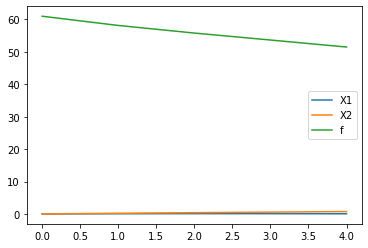

In [524]:
N=300
alpha = 9/634  #Calculated alpha value for this starting point
x1=0
x2=0
X1=[]
X2=[]
F=[]
for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    d1 = -(2*(x1-2) + 11*x2)
    d2 = -(2*(x2-7) + 11*x1)
    x1 = x1 + d1*alpha
    x2 = x2 + d2*alpha
     #If x1 or x2 becomes invalid f is calculated no further
    if(x1<0 or x2<0):
        break
plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('X1 = ',X1[-1])
print('X2 = ',X2[-1])
print('f = ',F[-1])

X1 =  0.22344598851283048
X2 =  2.998037603341132
f =  34.540741414651905


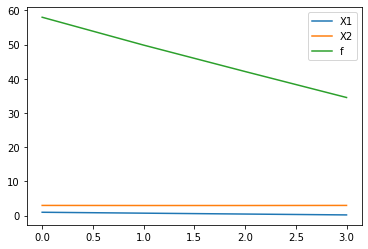

In [525]:
N=300
alpha = 1/117
x1=1
x2=3
X1=[]
X2=[]
F=[]
for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    d1 = -(2*(x1-2) + 11*x2)
    d2 = -(2*(x2-7) + 11*x1)
    x1 = x1 + d1*alpha
    x2 = x2 + d2*alpha
    if(x1<0 or x2<0):
        break
plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('X1 = ',X1[-1])
print('X2 = ',X2[-1])
print('f = ',F[-1])

X1 =  0.32445520581113807
X2 =  2.9346246973365617
f =  37.80842357051985


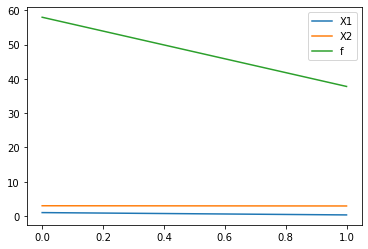

In [526]:
N=300
alpha = 9/413
x1=1
x2=3
X1=[]
X2=[]
F=[]
for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    #F is diffrentitaed
    d1 = -(2*(x1-2) + 11*x2)
    d2 = -(2*(x2-7) + 11*x1)
    #old value plus alpha by d
    x1 = x1 + d1*alpha
    x2 = x2 + d2*alpha
    if(x1<0 or x2<0):
        break
plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('X1 = ',X1[-1])
print('X2 = ',X2[-1])
print('f = ',F[-1])

# Question 4 part B

x1=  0.3076923076923077
x2=  1.076923076923077
F =  49.591715976331365
2


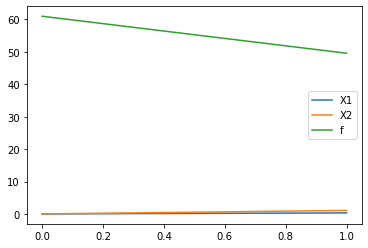

In [527]:
x1=0   #Chosen starting point
x2=0
det = -1/117 #Calculated determinent
N=500
X1=[]
X2=[]
F =[]

for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    #F is Diffrentiated to find d1 and d2
    d1 = 2*(x1 - 2) + 11*x2
    d2 = 2*(x2 - 7) + 11*x1
    #These are diffrentiated and multiplied by the determinent H-1(x) Each position in the matrix is repersented as ddxx
    dd11= 2 *det
    dd12=-11*det
    dd21=-11*det
    dd22= 2 *det
    #Calculation of x1 and x2
    x1=x1+d1*-(dd11 + dd21)
    x2=x2+d2*-(dd12 + dd22)
    #If x1 or x2 becomes invalid f is calculated no further
    if(x1<0 or x2<0):
        break


plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('x1= ',X1[-1])
print('x2= ',X2[-1])
print('F = ',F[-1])
print(len(F))

x1=  0.3076923076923066
x2=  1.0769230769230766
F =  49.59171597633135
2


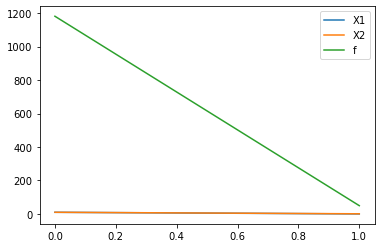

In [528]:
x1=10
x2=10
det = -1/117
N=500
X1=[]
X2=[]
F =[]

for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    d1 = 2*(x1 - 2) + 11*x2
    d2 = 2*(x2 - 7) + 11*x1
    
    dd11= 2 *det
    dd12=-11*det
    dd21=-11*det
    dd22= 2 *det
    
    x1=x1+d1*-(dd11 + dd21)
    x2=x2+d2*-(dd12 + dd22)
    if(x1<0 or x2<0):
        break


plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('x1= ',X1[-1])
print('x2= ',X2[-1])
print('F = ',F[-1])
print(len(F))

x1=  0.3076923076923075
x2=  1.0769230769230766
F =  49.591715976331365


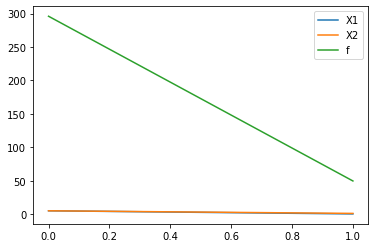

In [529]:
x1=5
x2=5
det = -1/117
N=500
X1=[]
X2=[]
F =[]

for iter in range(0,N):
    X1.append(x1)
    X2.append(x2)
    F.append((x1-2)**2 + (x2-7)**2 + 11*x1*x2 + 8)
    d1 = 2*(x1 - 2) + 11*x2
    d2 = 2*(x2 - 7) + 11*x1
    
    dd11= 2 *det
    dd12=-11*det
    dd21=-11*det
    dd22= 2 *det
    
    x1=x1+d1*-(dd11 + dd21)
    x2=x2+d2*-(dd12 + dd22)
    if(x1<0 or x2<0):
        break


plt.plot(range(0,len(X1)),X1,label='X1')
plt.plot(range(0,len(X2)),X2,label='X2')
plt.plot(range(0,len(F)),F,label='f')
plt.legend()
print('x1= ',X1[-1])
print('x2= ',X2[-1])
print('F = ',F[-1])